In [1]:
import numpy as np
import matplotlib.pyplot as plt

from landlab import VoronoiDelaunayGrid
import landlab.plot

In [2]:
class ShallowIceApproximation:
    
    def __init__(self, grid, initial_bedrock, initial_thickness, mass_balance):
        
        # Set constants, kg/m/s
        self.sec_per_a = 31536000 # appx. seconds per year
        self.rho = 917 # kg m^-3
        self.g = 9.81 # m s^-2
        self.n = 3
        self.A = 6.8e-24 # s^-1 Pa^-3, see Cuffey and Paterson (2010)
        self.flow_coeff = (2 * self.A) / (self.n + 2)
        self.CFL = 0.05 # constant for CFL condition
        
        self.grid = grid
        
        self.stable_time_step = 0.0
        self.time_elapsed = 0.0
    
        # Add all of the field variables
        if 'bedrock_elevation' not in self.grid.at_node:
            self.grid.add_field('bedrock_elevation', initial_bedrock, at = 'node')
            
        if 'ice_thickness' not in self.grid.at_node:
            self.grid.add_field('ice_thickness', initial_thickness, at = 'node')
            
        if 'surface_elevation' not in self.grid.at_node:
            initial_surface = self.grid.at_node['bedrock_elevation'] + self.grid.at_node['ice_thickness']
            self.grid.add_field('surface_elevation', initial_surface, at = 'node')
        
        if 'mass_balance' not in self.grid.at_node:
            self.grid.add_field('mass_balance', mass_balance, at = 'node')
            
        if 'velocity' not in self.grid.at_link:
            self.grid.add_zeros('velocity', at = 'link')
            
        if 'ice_flux' not in self.grid.at_link:
            self.grid.add_zeros('ice_flux', at = 'link')
    
    # Calculate the depth-integrated ice velocity at each node
    def solve_stress_balance(self):
        
        # Map thickness and surface slope to links, using upwind scheme
        self.ice_thickness_at_links = self.grid.map_value_at_max_node_to_link('ice_thickness', 'ice_thickness')
        self.slope = np.abs(self.grid.calc_grad_at_link('surface_elevation'))
        
        # Driving stress = (rho * g * S)^n * H^n+1
        self.driving_stress = (
            (self.rho * self.g * self.slope)**self.n
            * self.ice_thickness_at_links**(self.n + 1)
        )
        
        # Velocity = flow coefficient * driving stress
        self.grid.at_link['velocity'] = self.flow_coeff * self.driving_stress
        
        # Flux = velocity * ice thickness
        self.grid.at_link['ice_flux'] = self.grid.at_link['velocity'] * self.ice_thickness_at_links
        
    def calculate_stable_time_step(self):
         self.stable_time_step = (self.CFL * self.grid.node_x.max() / self.grid.number_of_nodes) / np.abs(self.grid.at_link['velocity']).max()

# Each time step, update the ice velocity and ice flux, then update the ice thickness by forward Euler    
    def run_one_step(self):
        
        # Update the ice velocity and ice flux
        self.solve_stress_balance()
        
        # Calculate the stable time step
        self.calculate_stable_time_step()
        
        # Calculate the change in thickness
        self.grid.at_node['ice_thickness'] += self.grid.at_node['mass_balance'] * self.stable_time_step 
        self.grid.at_node['ice_thickness'] -= self.grid.calc_flux_div_at_node('ice_flux') * self.stable_time_step
        
        self.time_elapsed += self.stable_time_step
        
        # Where the ice thickness has gone below zero, set it to equal zero
        self.grid.at_node['ice_thickness'] = np.where(self.grid.at_node['ice_thickness'] >= 0, self.grid.at_node['ice_thickness'], 0)
        
        # Recalculate the surface elevation
        self.grid.at_node['surface_elevation'] = self.grid.at_node['bedrock_elevation'] + self.grid.at_node['ice_thickness']

In [24]:
nodes = 10000
box = 100000
vdg = VoronoiDelaunayGrid(np.random.rand(nodes)*box, np.random.rand(nodes)*box)

initial_bedrock = np.zeros(nodes)
mass_balance = np.zeros(nodes)
initial_thickness = 1000 * np.exp(-(((vdg.x_of_node - box/2) / (box/3))**2 + ((vdg.y_of_node - box/2) / (box/3))**2)) * np.random.rand(1)

sia = ShallowIceApproximation(vdg, initial_bedrock, initial_thickness, mass_balance)

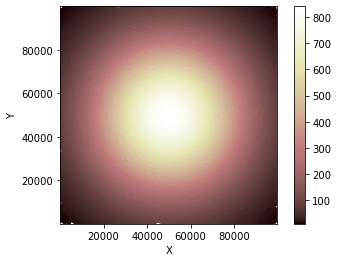

In [25]:
landlab.plot.imshow_grid(vdg, 'ice_thickness')

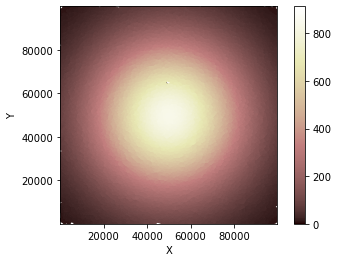

In [26]:
time_steps = []
max_velocities = []
max_thicknesses = []
max_slopes = []

mean_velocities = []
mean_thicknesses = []
mean_slopes = []

for i in range(500):
    sia.run_one_step()
    
    time_steps.append(sia.stable_time_step)
    max_velocities.append(sia.grid.at_link['velocity'].max())
    max_thicknesses.append(sia.grid.at_node['ice_thickness'].max())
    max_slopes.append(sia.slope.max())
    
    mean_velocities.append(sia.grid.at_link['velocity'].mean())
    mean_thicknesses.append(sia.grid.at_node['ice_thickness'].mean())
    mean_slopes.append(sia.slope.mean())

# print(sia.time_elapsed / 60 / 60 / 24)
landlab.plot.imshow_grid(vdg, 'ice_thickness')

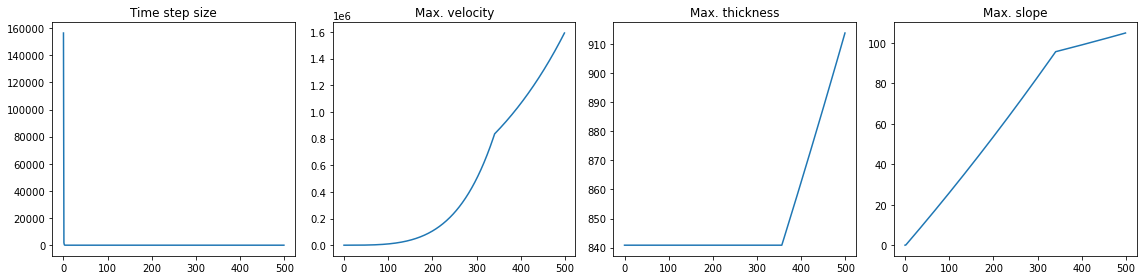

In [27]:
fig, ax = plt.subplots(1, 4, figsize = (16, 4))

ax[0].plot(time_steps)
ax[0].set_title('Time step size')

ax[1].plot(max_velocities)
ax[1].set_title('Max. velocity')

ax[2].plot(max_thicknesses)
ax[2].set_title('Max. thickness')

ax[3].plot(max_slopes)
ax[3].set_title('Max. slope')

plt.tight_layout()
plt.show()

In [21]:
max_velocities[0] * 3.14e7

352.13241538648651

In [23]:
max_slopes[0]

0.02573123497498633

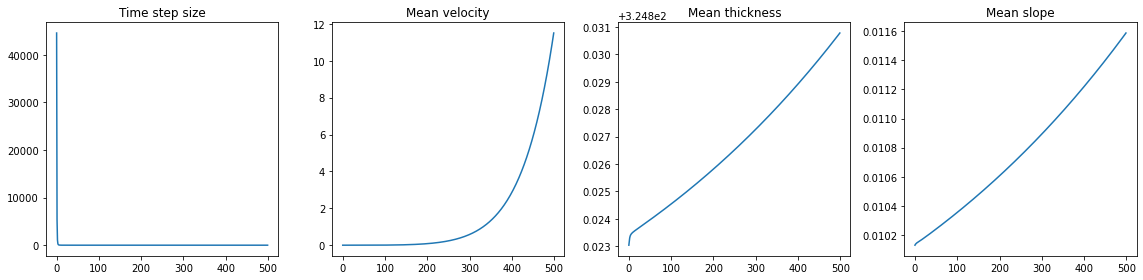

In [22]:
fig, ax = plt.subplots(1, 4, figsize = (16, 4))

ax[0].plot(time_steps)
ax[0].set_title('Time step size')

ax[1].plot(mean_velocities)
ax[1].set_title('Mean velocity')

ax[2].plot(mean_thicknesses)
ax[2].set_title('Mean thickness')

ax[3].plot(mean_slopes)
ax[3].set_title('Mean slope')

plt.tight_layout()
plt.show()